In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/Users/libilly/data/elastic-notebook/data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop, Normalize

import glob
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
SEED = 42

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [4]:
glob.glob("/Users/libilly/data/elastic-notebook/data/paddy-disease-classification/*")

In [5]:
set_seed(SEED)

train_val_images = glob.glob("/Users/libilly/data/elastic-notebook/data/paddy-disease-classification/train_images/*/*")
test_images = glob.glob("/Users/libilly/data/elastic-notebook/data/paddy-disease-classification/test_images/*")


def train_val_split(images_list, train_size):
    n = int(len(images_list) * train_size)
    train_list = images_list[:n]
    val_list = images_list[n:]
    return train_list, val_list

random.shuffle(train_val_images)
train_images, val_images = train_val_split(train_val_images, train_size=0.9)

print(len(train_images), len(val_images), len(test_images))

train_images[:2], val_images[:2], test_images[:2]

9366 1041 3469


In [6]:
transform = Compose([
    CenterCrop(446),
    Resize((256, 256)),
    ToTensor(),
    Normalize([0.4965, 0.5858, 0.2238], [0.2222, 0.2218, 0.1968])
])

In [7]:
target_names = [st.split("/")[-1] for st in glob.glob("/Users/libilly/data/elastic-notebook/data/paddy-disease-classification/train_images/*")]
target_names.sort()
target_names

In [8]:
target_2_int = {}
counter = 0
for _ in target_names:
    target_2_int[_] = counter
    counter += 1

target_2_int

In [9]:
int_2_target = {i:t for t, i in target_2_int.items()}

int_2_target

In [10]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = img_path.split("/")[-2]
            label = target_2_int[label]
        else:
            label = img_path.split("/")[-1].split(".")[0]
        
        label = int(label)
        return image, label

In [12]:
training_data = ImageDataset(train_images, transform, train=True)
val_data = ImageDataset(val_images, transform, train=True)

test_data = ImageDataset(test_images, transform, train=False)

In [13]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [14]:
for x, y in train_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256])
tensor([7, 7, 9, 9, 3, 8, 9, 7, 9, 0, 8, 7, 3, 5, 2, 9, 5, 7, 9, 5, 4, 5, 4, 0,
        4, 7, 5, 3, 4, 2, 3, 5])


In [15]:
for x, y in val_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256])
tensor([7, 4, 3, 3, 3, 7, 5, 6, 5, 5, 6, 4, 8, 2, 9, 3, 2, 9, 7, 7, 5, 5, 8, 8,
        6, 3, 8, 6, 5, 3, 3, 9])


In [16]:
for x, y in test_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([1, 3, 256, 256])
tensor([202919])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


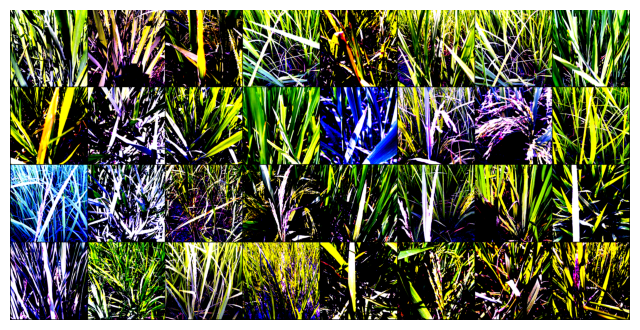

In [17]:
fig = plt.figure(figsize=(8, 8))
img = make_grid(next(iter(train_dataloader))[0], nrow=8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available()else "cpu"
print(f"Using {device} device")

Using mps device


In [25]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


get_mean_and_std(train_dataloader)

In [20]:
set_seed(SEED)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model.fc = nn.Linear(512, 10)
model.to(device);

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/libilly/.cache/torch/hub/v0.10.0.zip
/Users/libilly/kishu-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/libilly/kishu-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/libilly/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|████████████████████████████████████████████████████████████████████████████████████████

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 4

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

In [ ]:
test_label = np.zeros((len(test_dataloader.dataset,)), dtype=object)
test_id = np.zeros((len(test_dataloader.dataset,)), dtype=object)


for i, (X, y) in enumerate(test_dataloader):
    X = X.to(device)
    model.eval()
    pred = model(X)
    test_label[i] = int_2_target[torch.argmax(pred, dim=1).item()]
    test_id[i] = str(y.item()) + ".jpg"

In [ ]:
sub_df = pd.DataFrame({"image_id": test_id, "label": test_label})

In [ ]:
sub_df.head()

In [ ]:
sub_df.to_csv("submission.csv", index=False)